In [82]:
import uproot
import awkward as ak
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

import vector
vector.register_awkward() #Allows Awkward array records to be interpreted as vectors

#load ROOT file
events = uproot.open('input/reco_djangoh_18_275.edm4hep.root:events')
print(events)

#To check branches
#events.keys()

<TTree 'events' (15 branches) at 0x7f85c9c3dac0>


### **Inclusive Kinematics -- Truth Level**

In [83]:
#Get True Inclusive Kinematics Branches
arrays = events.arrays(['InclusiveKinematicsTruth.x','InclusiveKinematicsTruth.Q2'])
print("")
print(arrays.type)
print("")

x = arrays['InclusiveKinematicsTruth.x']
Q2 = arrays['InclusiveKinematicsTruth.Q2']
print(x)
print("")

#Flatten for later cuts on sum
x_flat = ak.flatten(x)
Q2_flat = ak.flatten(Q2)


10000 * {"InclusiveKinematicsTruth.x": var * float32, "InclusiveKinematicsTruth.Q2": var * float32}

[[0.0184], [0.145], [0.087], [0.178], ... [0.0203], [0.0148], [0.0186], [0.0609]]



### **Generated Particles**

In [85]:
#Get MCParticles Branches
arrays = events.arrays(filter_name="MCParticles/*")
print("")
print(arrays.type)
print("")

#Select only final-state generated particles, and exclude secondaries
cut_primary = arrays["MCParticles.generatorStatus"]==1

px = arrays["MCParticles.momentum.x"][cut_primary]
py = arrays["MCParticles.momentum.y"][cut_primary]
pz = arrays["MCParticles.momentum.z"][cut_primary]
mass = arrays["MCParticles.mass"][cut_primary]

particles = vector.zip({
    "px": px,
    "py": py,
    "pz": pz,
    "mass": mass,
})

#For testing
###
pt = np.sqrt(px**2+py**2)
mom = np.sqrt(px**2+py**2+pz**2)
energy = np.sqrt(mom**2+mass**2)
theta = np.arccos(pz/mom)
eta = -1.*np.log( np.tan(theta/2.) )

#Check conservation of energy -- should be ~ 18+275 = 293 GeV
e_sum = (ak.sum(energy,axis=-1))
print("Total energy of final-state particles:")
print(e_sum)
print("")

print("energy comparison:")
print(energy)
print(ak.count(energy,axis=-1))
print(particles.energy)
print(ak.count(particles.energy,axis=-1))
print("")
print("eta comparison:")
print(eta)
print(ak.count(eta,axis=-1))
print(particles.eta)
print(ak.count(particles.eta,axis=-1))
print("")
###

#Rotate particles so that angles are defined relative to proton beam direction
particles_star = particles.rotateY(25./1000.)
print(type(particles))
print(type(particles_star))
energy_star = particles_star.energy #should be same as unrotated
px_star = particles_star.px
py_star = particles_star.py #should be same as unrotated
pz_star = particles_star.pz
eta_star = particles_star.eta
empz_star = energy_star - pz_star

#For testing
###
print("energy comparison:")
print(energy)
print(ak.count(energy,axis=-1))
print(energy_star)
print(ak.count(energy_star,axis=-1))
print("")
print("eta comparison:")
print(eta)
print(ak.count(eta,axis=-1))
print(eta_star)
print(ak.count(eta_star,axis=-1))
print("")
###

#Total E-pz* for various eta* cuts
#eta* > 1.0
e1 = energy_star[(eta_star>1)] #should be same as using unrotated energy
e1_sum = ak.sum(e1,axis=-1)
e14 = energy_star[(eta_star>1) & (eta_star<4)] #should be same as using unrotated energy
e14_sum = ak.sum(e14,axis=-1)

empz1 = empz_star[(eta_star>1)]
print("Eta* > +1:")
print(empz1)
print(ak.count(empz1,axis=-1))

empz1_sum = ak.sum(empz1,axis=-1)
print(empz1_sum)
print("")

#eta* > 3.0
e3 = energy_star[(eta_star>3)] #should be same as using unrotated energy
e3_sum = (ak.sum(e3,axis=-1))
e34 = energy_star[(eta_star>1) & (eta_star<4)] #should be same as using unrotated energy
e34_sum = ak.sum(e34,axis=-1)

empz3 = empz_star[(eta_star>3)]
print("Eta* > +3:")
print(empz3)
print(ak.count(empz3,axis=-1))

empz3_sum = ak.sum(empz3,axis=-1)
print(empz3_sum)
print("")

#High-x events: eta* > 1.0 & x > 0.2
empz1_highx = empz1_sum[x_flat>0.2]


10000 * {"MCParticles.PDG": var * int32, "MCParticles.generatorStatus": var * int32, "MCParticles.simulatorStatus": var * int32, "MCParticles.charge": var * float32, "MCParticles.time": var * float32, "MCParticles.mass": var * float64, "MCParticles.vertex.x": var * float64, "MCParticles.vertex.y": var * float64, "MCParticles.vertex.z": var * float64, "MCParticles.endpoint.x": var * float64, "MCParticles.endpoint.y": var * float64, "MCParticles.endpoint.z": var * float64, "MCParticles.momentum.x": var * float32, "MCParticles.momentum.y": var * float32, "MCParticles.momentum.z": var * float32, "MCParticles.momentumAtEndpoint.x": var * float32, "MCParticles.momentumAtEndpoint.y": var * float32, "MCParticles.momentumAtEndpoint.z": var * float32, "MCParticles.spin.x": var * float32, "MCParticles.spin.y": var * float32, "MCParticles.spin.z": var * float32, "MCParticles.colorFlow.a": var * int32, "MCParticles.colorFlow.b": var * int32, "MCParticles.parents_begin": var * uint32, "MCParticles.

### Calorimeter Reconstruction

In [86]:
#Get Calorimeter Branches
#HCal endcap -- Use merged hits: these integrate over all z cells with same x,y position; merged z position at front face
#HCal insert -- Use merged hits
#Ecal endcap -- Use reconstructed hits: only one energy value per x,y position; z position at front face
#Ecal insert -- Use reconstructed hits

hcal_arrays = events.arrays(['HcalEndcapPMergedHits.energy',
                             'HcalEndcapPMergedHits.position.x',
                             'HcalEndcapPMergedHits.position.y',
                             'HcalEndcapPMergedHits.position.z'])

hcal_insert_arrays = events.arrays(['HcalEndcapPInsertMergedHits.energy',
                                    'HcalEndcapPInsertMergedHits.position.x',
                                    'HcalEndcapPInsertMergedHits.position.y',
                                    'HcalEndcapPInsertMergedHits.position.z'])

ecal_arrays = events.arrays(['EcalEndcapPHitsReco.energy',
                             'EcalEndcapPHitsReco.position.x',
                             'EcalEndcapPHitsReco.position.y',
                             'EcalEndcapPHitsReco.position.z'])

ecal_insert_arrays = events.arrays(['EcalEndcapPInsertHitsReco.energy',
                                    'EcalEndcapPInsertHitsReco.position.x',
                                    'EcalEndcapPInsertHitsReco.position.y',
                                    'EcalEndcapPInsertHitsReco.position.z'])

print("")
print(hcal_arrays.type)
print(hcal_insert_arrays.type)
print(ecal_arrays.type)
print(ecal_insert_arrays.type)
print("")

#Combine in one set of Awkward arrays (for easier rotation and summing)
cal_energy = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.energy'],
                             hcal_insert_arrays['HcalEndcapPInsertMergedHits.energy'],
                             ecal_arrays['EcalEndcapPHitsReco.energy'],
                             ecal_insert_arrays['EcalEndcapPInsertHitsReco.energy']),
                            axis=-1)

cal_posx = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.x'],
                           hcal_insert_arrays['HcalEndcapPInsertMergedHits.position.x'],
                           ecal_arrays['EcalEndcapPHitsReco.position.x'],
                           ecal_insert_arrays['EcalEndcapPInsertHitsReco.position.x']),
                          axis=-1)

cal_posy = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.y'],
                           hcal_insert_arrays['HcalEndcapPInsertMergedHits.position.y'],
                           ecal_arrays['EcalEndcapPHitsReco.position.y'],
                           ecal_insert_arrays['EcalEndcapPInsertHitsReco.position.y']),
                          axis=-1)

cal_posz = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.z'],
                           hcal_insert_arrays['HcalEndcapPInsertMergedHits.position.z'],
                           ecal_arrays['EcalEndcapPHitsReco.position.z'],
                           ecal_insert_arrays['EcalEndcapPInsertHitsReco.position.z']),
                          axis=-1)

#For testing
###
print("Test output:")
print(ak.count(hcal_arrays['HcalEndcapPMergedHits.energy'],axis=-1))
print(ak.count(hcal_insert_arrays['HcalEndcapPInsertMergedHits.energy'],axis=-1))
print(ak.count(ecal_arrays['EcalEndcapPHitsReco.energy'],axis=-1))
print(ak.count(ecal_insert_arrays['EcalEndcapPInsertHitsReco.energy'],axis=-1))
print(ak.count(cal_energy,axis=-1))
print("")
###

#Create hit position vector and reconstucted momentum vector
cal_pos_vec = vector.zip({
    "x": cal_posx,
    "y": cal_posy,
    "z": cal_posz,
})

cal_pos_unit = cal_pos_vec.unit()
cal_mom_vec = cal_energy*cal_pos_unit

#For testing
###
print("Test output:")
print(type(cal_pos_vec))
print(type(cal_pos_unit))
print(type(cal_mom_vec))

print(cal_pos_vec)
print(cal_pos_unit)
print(cal_energy)
print(cal_mom_vec)
print("")
###

#Rotate hit momentum vectors to be defined relative to proton beam direction
cal_mom_vec_star = cal_mom_vec.rotateY(25./1000.)
cal_energy_star = cal_mom_vec_star.mag #should be same as unrotated
cal_px_star = cal_mom_vec_star.x
cal_py_star = cal_mom_vec_star.y #should be same as unrotated
cal_pz_star = cal_mom_vec_star.z
cal_eta_star = cal_mom_vec_star.eta
cal_empz_star = cal_energy_star - cal_pz_star

#For testing
###
print("Test output:")
print(cal_energy)
print(cal_energy_star)
print(cal_mom_vec.y)
print(cal_py_star)
print(cal_mom_vec.eta)
print(cal_eta_star)
print("")
###

#Total Reconstructed E and E-pz* for various eta* cuts -- use simple (unweighted) sum
#eta* > 1.0
cal_e1 = cal_energy_star[(cal_eta_star>1)] #should be same as using unrotated energy
cal_e1_sum = ak.sum(cal_e1,axis=-1)
cal_e14 = cal_energy_star[(cal_eta_star>1) & (cal_eta_star<4)] #should be same as using unrotated energy
cal_e14_sum = ak.sum(cal_e14,axis=-1)

cal_empz1 = cal_empz_star[(cal_eta_star>1)]
cal_empz1_sum = ak.sum(cal_empz1,axis=-1)

#eta* > 3.0
cal_e3 = cal_energy_star[(cal_eta_star>3)] #should be same as using unrotated energy
cal_e3_sum = ak.sum(cal_e3,axis=-1)
cal_e34 = cal_energy_star[(cal_eta_star>1) & (cal_eta_star<4)] #should be same as using unrotated energy
cal_e34_sum = ak.sum(cal_e34,axis=-1)

cal_empz3 = cal_empz_star[(cal_eta_star>3)]
cal_empz3_sum = ak.sum(cal_empz3,axis=-1)

#For testing
###
print("Test output:")
print(cal_e1_sum)
print(cal_empz1_sum)
print(cal_empz3_sum)
print("")
###

#High-x events: eta* > 1.0 & x > 0.2
cal_empz1_highx = cal_empz1_sum[x_flat>0.2]


10000 * {"HcalEndcapPMergedHits.energy": var * float32, "HcalEndcapPMergedHits.position.x": var * float32, "HcalEndcapPMergedHits.position.y": var * float32, "HcalEndcapPMergedHits.position.z": var * float32}
10000 * {"HcalEndcapPInsertMergedHits.energy": var * float32, "HcalEndcapPInsertMergedHits.position.x": var * float32, "HcalEndcapPInsertMergedHits.position.y": var * float32, "HcalEndcapPInsertMergedHits.position.z": var * float32}
10000 * {"EcalEndcapPHitsReco.energy": var * float32, "EcalEndcapPHitsReco.position.x": var * float32, "EcalEndcapPHitsReco.position.y": var * float32, "EcalEndcapPHitsReco.position.z": var * float32}
10000 * {"EcalEndcapPInsertHitsReco.energy": var * float32, "EcalEndcapPInsertHitsReco.position.x": var * float32, "EcalEndcapPInsertHitsReco.position.y": var * float32, "EcalEndcapPInsertHitsReco.position.z": var * float32}

Test output:
[142, 179, 135, 298, 229, 142, 169, 317, ... 293, 26, 294, 182, 314, 151, 139, 65]
[103, 146, 0, 171, 122, 185, 52, 2

### Repeat Calorimeter Reconstruction -- No Insert

In [87]:
#Combine in one set of Awkward arrays (for easier rotation and summing)
cal_noin_energy = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.energy'],
                             ecal_arrays['EcalEndcapPHitsReco.energy'],),
                            axis=-1)

cal_noin_posx = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.x'],
                           ecal_arrays['EcalEndcapPHitsReco.position.x'],),
                          axis=-1)

cal_noin_posy = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.y'],
                           ecal_arrays['EcalEndcapPHitsReco.position.y'],),
                          axis=-1)

cal_noin_posz = ak.concatenate((hcal_arrays['HcalEndcapPMergedHits.position.z'],
                           ecal_arrays['EcalEndcapPHitsReco.position.z'],),
                          axis=-1)

#Create hit position vector and reconstucted momentum vector
cal_noin_pos_vec = vector.zip({
    "x": cal_noin_posx,
    "y": cal_noin_posy,
    "z": cal_noin_posz,
})

cal_noin_pos_unit = cal_noin_pos_vec.unit()
cal_noin_mom_vec = cal_noin_energy*cal_noin_pos_unit

#Rotate hit momentum vectors to be defined relative to proton beam direction
cal_noin_mom_vec_star = cal_noin_mom_vec.rotateY(25./1000.)
cal_noin_energy_star = cal_noin_mom_vec_star.mag #should be same as unrotated
cal_noin_px_star = cal_noin_mom_vec_star.x
cal_noin_py_star = cal_noin_mom_vec_star.y #should be same as unrotated
cal_noin_pz_star = cal_noin_mom_vec_star.z
cal_noin_eta_star = cal_noin_mom_vec_star.eta
cal_noin_empz_star = cal_noin_energy_star - cal_noin_pz_star

#Total Reconstructed E and E-pz* for various eta* cuts -- use simple (unweighted) sum
#eta* > 1.0
cal_noin_e1 = cal_noin_energy_star[(cal_noin_eta_star>1)] #should be same as using unrotated energy
cal_noin_e1_sum = ak.sum(cal_noin_e1,axis=-1)
cal_noin_e14 = cal_noin_energy_star[(cal_noin_eta_star>1) & (cal_noin_eta_star<4)] #should be same as using unrotated energy
cal_noin_e14_sum = ak.sum(cal_noin_e14,axis=-1)

cal_noin_empz1 = cal_noin_empz_star[(cal_noin_eta_star>1)]
cal_noin_empz1_sum = ak.sum(cal_noin_empz1,axis=-1)

#eta* > 3.0
cal_noin_e3 = cal_noin_energy_star[(cal_noin_eta_star>3)] #should be same as using unrotated energy
cal_noin_e3_sum = ak.sum(cal_noin_e3,axis=-1)
cal_noin_e34 = cal_noin_energy_star[(cal_noin_eta_star>1) & (cal_noin_eta_star<4)] #should be same as using unrotated energy
cal_noin_e34_sum = ak.sum(cal_noin_e34,axis=-1)

cal_noin_empz3 = cal_noin_empz_star[(cal_noin_eta_star>3)]
cal_noin_empz3_sum = ak.sum(cal_noin_empz3,axis=-1)

#High-x events: eta* > 1.0 & x > 0.2
cal_noin_empz1_highx = cal_noin_empz1_sum[x_flat>0.2]

### Plotting

Generated Kinematics:



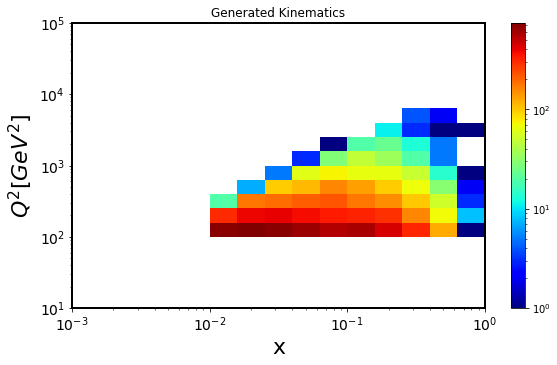


Eta* > 1.0:



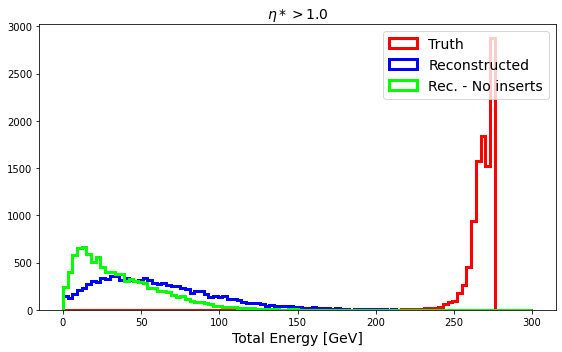

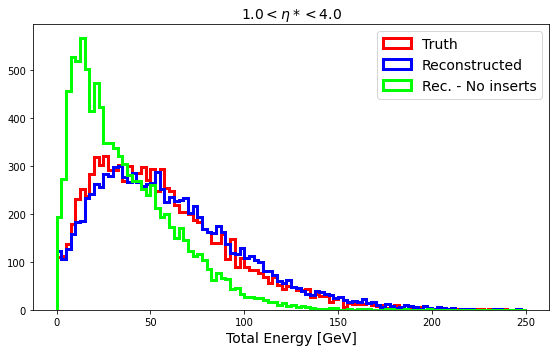

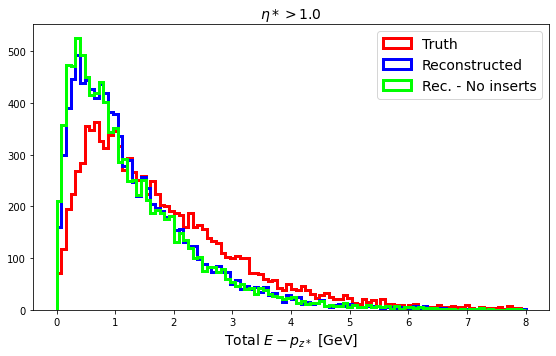


Eta* > 3.0:



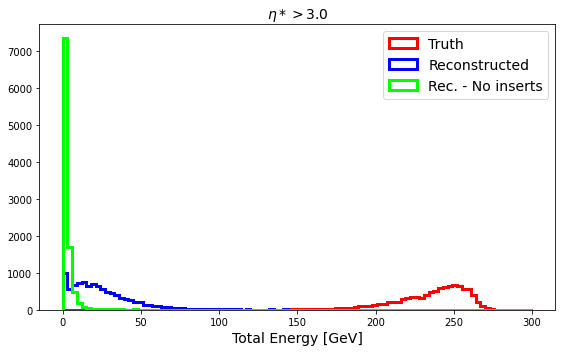

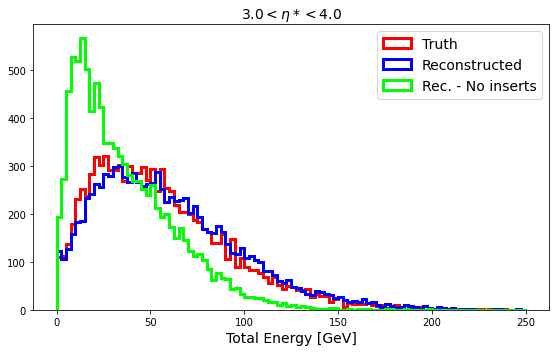

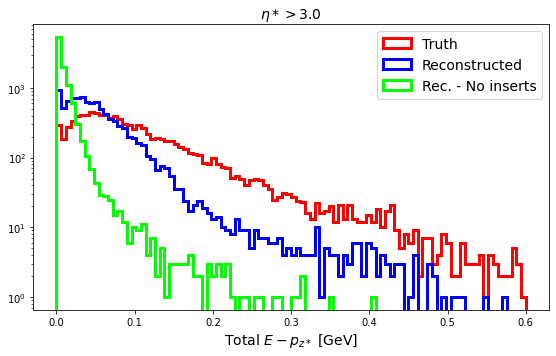


x > 0.2 and Eta* > 1.0:



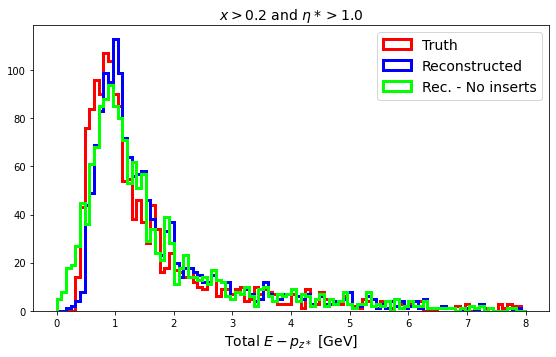

In [90]:
#True and Reconstructed Energy and Total E-pz*

#Output pdf file
pp1 = PdfPages('pendcap_analysis_djangoh.pdf')

#Plot generated Q2 vs. x
print("Generated Kinematics:")
print("")
x_bins = np.logspace(-3,0,16)
Q2_bins = np.logspace(1,5,21)

#Need to flatten and then convert to numpy array for 2D histogram
counts, xedges, yedges, im = plt.hist2d(np.array(ak.flatten(x)),
                                        np.array(ak.flatten(Q2)),
                                        bins=[x_bins,Q2_bins],
                                        norm=mpl.colors.LogNorm(),cmap=plt.cm.jet)
plt.title("Generated Kinematics")
plt.xlabel("x")
plt.ylabel("$Q^{2} [GeV^2]$")
plt.xscale("log")
plt.yscale("log")

axes = plt.gca()
axes.xaxis.label.set_size(22)
axes.yaxis.label.set_size(22)
axes.tick_params(axis='both',labelsize=14)
axes.spines["left"].set_linewidth(2)
axes.spines["right"].set_linewidth(2)
axes.spines["bottom"].set_linewidth(2)
axes.spines["top"].set_linewidth(2)

plt.colorbar(im)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

print("")

#eta* > 1.0
print("Eta* > 1.0:")
print("")
plt.hist(e1_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,300])
plt.hist(cal_e1_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,300])
plt.hist(cal_noin_e1_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,300])
plt.xlabel("Total Energy [GeV]",fontsize=14)
plt.title('$\eta* > 1.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

plt.hist(e14_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,250])
plt.hist(cal_e14_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,250])
plt.hist(cal_noin_e14_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,250])
plt.xlabel("Total Energy [GeV]",fontsize=14)
plt.title('$1.0 < \eta* < 4.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

plt.hist(empz1_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,8])
plt.hist(cal_empz1_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,8])
plt.hist(cal_noin_empz1_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,8])
plt.xlabel("Total $E - p_{z*}$ [GeV]",fontsize=14)
plt.title('$\eta* > 1.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

print("")

#eta* > 3.0
print("Eta* > 3.0:")
print("")
plt.hist(e3_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,300])
plt.hist(cal_e3_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,300])
plt.hist(cal_noin_e3_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,300])
plt.xlabel("Total Energy [GeV]",fontsize=14)
plt.title('$\eta* > 3.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

plt.hist(e34_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,250])
plt.hist(cal_e34_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,250])
plt.hist(cal_noin_e34_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,250])
plt.xlabel("Total Energy [GeV]",fontsize=14)
plt.title('$3.0 < \eta* < 4.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

plt.hist(empz3_sum,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,0.6])
plt.hist(cal_empz3_sum,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,0.6])
plt.hist(cal_noin_empz3_sum,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,0.6])
plt.title('$\eta* > 3.0$',fontsize=14)
plt.xlabel("Total $E - p_{z*}$ [GeV]",fontsize=14)
plt.yscale("log")
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

print("")

#High-x events: eta* > 1.0 & x > 0.2
print("x > 0.2 and Eta* > 1.0:")
print("")

plt.hist(empz1_highx,label="Truth",histtype='step',ec='red',
         lw=3,bins=100,range=[0,8])
plt.hist(cal_empz1_highx,label="Reconstructed",histtype='step',ec='blue',
         lw=3,bins=100,range=[0,8])
plt.hist(cal_noin_empz1_highx,label="Rec. - No inserts",histtype='step',ec='lime',
         lw=3,bins=100,range=[0,8])
plt.xlabel("Total $E - p_{z*}$ [GeV]",fontsize=14)
plt.title('$x > 0.2$ and $\eta* > 1.0$',fontsize=14)
plt.legend(fontsize=14)

#Figure Output
fig = plt.gcf()
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()
fig.savefig(pp1, format='pdf')

pp1.close()